<a href="https://colab.research.google.com/github/PaulinaPacyna/DL_speech_recognition/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can use this code in your notebook to load the data.

In [48]:
import librosa
import os
import json
import pickle
import zipfile
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import pandas as pd
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation, BatchNormalization
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2, l1

In [2]:
paths = [os.path.join(dp, f) for dp, dn, fn in os.walk('train/audio') for f in fn if f[-4:]=='.wav']
paths = pd.DataFrame(paths, columns=['path']) # .sample(n=1000).reset_index(drop=True)
paths['label'] = paths['path'].apply(lambda x: x.split('/')[-2])
paths

,path,label
0,train/audio\bed\00176480_nohash_0.wav,train
1,train/audio\bed\004ae714_nohash_0.wav,train
2,train/audio\bed\004ae714_nohash_1.wav,train
3,train/audio\bed\00f0204f_nohash_0.wav,train
4,train/audio\bed\00f0204f_nohash_1.wav,train
...,...,...
64722,train/audio\_background_noise_\dude_miaowing.wav,train
64723,train/audio\_background_noise_\exercise_bike.wav,train
64724,train/audio\_background_noise_\pink_noise.wav,train
64725,train/audio\_background_noise_\running_tap.wav,train


In [3]:
def audio2mel(path):
    y, sr = librosa.core.load(path=path)
    if len(y) > sr: # we set all to have lenght equal to 1 second 
        y = y[:sr] 
    else: # pad blank
        padding = sr - len(y)
        offset = padding // 2 
        y = np.pad(y, (offset, sr - len(y) - offset), 'constant')
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    return librosa.power_to_db(mel, ref= np.max).astype(np.float) 

def convert_wav_to_image(df):
    X = []
    for _,row in tqdm(df.iterrows(), total = df.shape[0]):
        x = audio2mel(row['path'])
        X.append(x.transpose())
    X = np.array(X) 
    return X
#os.chdir('/content/drive/MyDrive/DL3/')
if os.path.exists('X_train.npy') and os.path.exists('y_train.npy') and os.path.exists('class_names.npy'):
  X = np.load('X_train.npy', allow_pickle=True)
  y = np.load('y_train.npy', allow_pickle=True)
  classess = np.load('class_names.npy', allow_pickle=True)
else:
  X = convert_wav_to_image(paths)
  enc = OneHotEncoder() 
  y = enc.fit_transform(paths[['label']]).todense()
  classes = enc.get_feature_names()
  np.save('X_train.npy', X)
  np.save('y_train.npy', y)
  np.save('class_names.npy', classes)
X = (X - np.mean(X))/np.std(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [52]:
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(
    128,
    input_shape=X.shape[1:],
    return_sequences=True
))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [53]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [54]:
history_model = model.fit(X_train, y_train, epochs=30, validation_split = 0.3, callbacks=[early_stop])

Epoch 1/30
949/949 [==============================] - 71s 68ms/step - loss: 2.2974 - accuracy: 0.3215 - val_loss: 0.7879 - val_accuracy: 0.7709
Epoch 2/30
949/949 [==============================] - 63s 66ms/step - loss: 0.8171 - accuracy: 0.7692 - val_loss: 0.5508 - val_accuracy: 0.8421
Epoch 3/30
949/949 [==============================] - 61s 65ms/step - loss: 0.5818 - accuracy: 0.8383 - val_loss: 0.4527 - val_accuracy: 0.8717
Epoch 4/30
949/949 [==============================] - 61s 65ms/step - loss: 0.4714 - accuracy: 0.8664 - val_loss: 0.4093 - val_accuracy: 0.8843
Epoch 5/30
949/949 [==============================] - 61s 64ms/step - loss: 0.3964 - accuracy: 0.8882 - val_loss: 0.3838 - val_accuracy: 0.8917
Epoch 6/30
949/949 [==============================] - 61s 64ms/step - loss: 0.3549 - accuracy: 0.8992 - val_loss: 0.3677 - val_accuracy: 0.9001
Epoch 7/30
949/949 [==============================] - 62s 65ms/step - loss: 0.3260 - accuracy: 0.9048 - val_loss: 0.3346 - val_accuracy:

In [18]:
def accuracy(model):
    p = model.predict(X_test)
    return np.mean(np.argmax(p,1) == np.argmax(y_test,1))

In [55]:
accuracy(model)

0.9130617977528089

<AxesSubplot:>

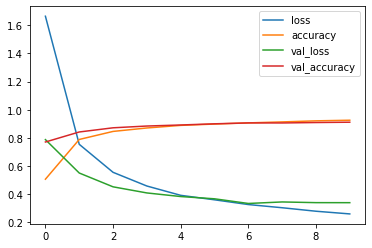

In [56]:
pd.DataFrame(history_model.history).plot()

**Model with different regularizations**

Epoch 1/30
949/949 [==============================] - 67s 66ms/step - loss: 3.5927 - accuracy: 0.2784 - val_loss: 1.1300 - val_accuracy: 0.7617
Epoch 2/30
949/949 [==============================] - 62s 65ms/step - loss: 1.1826 - accuracy: 0.7406 - val_loss: 0.8274 - val_accuracy: 0.8245
Epoch 3/30
949/949 [==============================] - 62s 65ms/step - loss: 0.9080 - accuracy: 0.8017 - val_loss: 0.7205 - val_accuracy: 0.8495
Epoch 4/30
949/949 [==============================] - 62s 65ms/step - loss: 0.7973 - accuracy: 0.8301 - val_loss: 0.7312 - val_accuracy: 0.8402
Epoch 5/30
949/949 [==============================] - 62s 65ms/step - loss: 0.7224 - accuracy: 0.8449 - val_loss: 0.6629 - val_accuracy: 0.8594
Epoch 6/30
949/949 [==============================] - 62s 65ms/step - loss: 0.6603 - accuracy: 0.8627 - val_loss: 0.6112 - val_accuracy: 0.8721
Epoch 7/30
949/949 [==============================] - 62s 65ms/step - loss: 0.6165 - accuracy: 0.8708 - val_loss: 0.5901 - val_accuracy:

<AxesSubplot:>

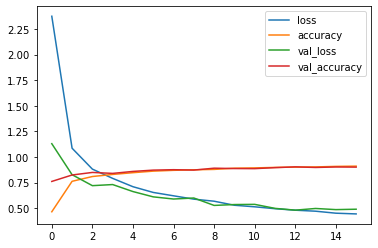

In [57]:
model_reg = Sequential()
model_reg.add(BatchNormalization())
model_reg.add(LSTM(
    128,
    input_shape=X.shape[1:],
    return_sequences=True,
    recurrent_regularizer=l2(0.01)
))
model_reg.add(Dropout(0.5))
model_reg.add(LSTM(128, return_sequences=True, recurrent_regularizer=l2(0.01)))
model_reg.add(Dropout(0.5))
model_reg.add(LSTM(128, recurrent_regularizer=l2(0.01)))
model_reg.add(Dense(128, kernel_regularizer=l2(0.01)))
model_reg.add(Dropout(0.5))
model_reg.add(Dense(y.shape[1]))
model_reg.add(Activation('softmax'))

model_reg.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
history_reg = model_reg.fit(X_train, y_train, epochs=30, validation_split = 0.3, callbacks=[early_stop])
              
print(accuracy(model_reg))

pd.DataFrame(history_reg.history).plot()

Epoch 1/30
949/949 [==============================] - 71s 68ms/step - loss: 9.5471 - accuracy: 0.2269 - val_loss: 1.3852 - val_accuracy: 0.7009
Epoch 2/30
949/949 [==============================] - 63s 66ms/step - loss: 1.4430 - accuracy: 0.6731 - val_loss: 1.0467 - val_accuracy: 0.7891
Epoch 3/30
949/949 [==============================] - 63s 66ms/step - loss: 1.0998 - accuracy: 0.7693 - val_loss: 0.9101 - val_accuracy: 0.8211
Epoch 4/30
949/949 [==============================] - 63s 66ms/step - loss: 0.9671 - accuracy: 0.8055 - val_loss: 0.8842 - val_accuracy: 0.8254
Epoch 5/30
949/949 [==============================] - 63s 66ms/step - loss: 0.8607 - accuracy: 0.8291 - val_loss: 0.7453 - val_accuracy: 0.8599
Epoch 6/30
949/949 [==============================] - 63s 66ms/step - loss: 0.8039 - accuracy: 0.8436 - val_loss: 0.6924 - val_accuracy: 0.8659
Epoch 7/30
949/949 [==============================] - 63s 66ms/step - loss: 0.7462 - accuracy: 0.8577 - val_loss: 0.6899 - val_accuracy:

<AxesSubplot:>

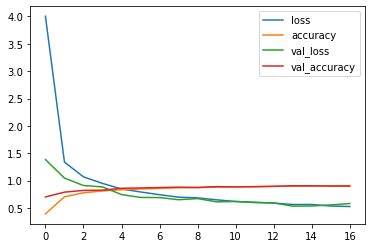

In [58]:
model_reg2 = Sequential()
model_reg2.add(BatchNormalization())
model_reg2.add(LSTM(
    128,
    input_shape=X.shape[1:],
    return_sequences=True,
    recurrent_regularizer=l2(0.1)
))
model_reg2.add(Dropout(0.5))
model_reg2.add(LSTM(128, return_sequences=True, recurrent_regularizer=l2(0.1)))
model_reg2.add(Dropout(0.5))
model_reg2.add(LSTM(128, recurrent_regularizer=l2(0.1)))
model_reg2.add(Dense(128, kernel_regularizer=l2(0.1)))
model_reg2.add(Dropout(0.5))
model_reg2.add(Dense(y.shape[1]))
model_reg2.add(Activation('softmax'))

model_reg2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
history_reg2 = model_reg2.fit(X_train, y_train, epochs=30, validation_split = 0.3, callbacks=[early_stop])
              
print(accuracy(model_reg2))

pd.DataFrame(history_reg2.history).plot()

Epoch 1/30
949/949 [==============================] - 72s 71ms/step - loss: 14.8511 - accuracy: 0.1438 - val_loss: 2.4185 - val_accuracy: 0.5379
Epoch 2/30
949/949 [==============================] - 66s 69ms/step - loss: 2.4034 - accuracy: 0.5594 - val_loss: 1.7265 - val_accuracy: 0.7598
Epoch 3/30
949/949 [==============================] - 65s 69ms/step - loss: 1.8024 - accuracy: 0.7441 - val_loss: 1.4984 - val_accuracy: 0.8097
Epoch 4/30
949/949 [==============================] - 66s 70ms/step - loss: 1.5756 - accuracy: 0.7932 - val_loss: 1.3423 - val_accuracy: 0.8421
Epoch 5/30
949/949 [==============================] - 68s 72ms/step - loss: 1.4271 - accuracy: 0.8242 - val_loss: 1.3024 - val_accuracy: 0.8520
Epoch 6/30
949/949 [==============================] - 66s 70ms/step - loss: 1.3489 - accuracy: 0.8389 - val_loss: 1.2294 - val_accuracy: 0.8663
Epoch 7/30
949/949 [==============================] - 67s 71ms/step - loss: 1.2749 - accuracy: 0.8553 - val_loss: 1.1679 - val_accuracy

<AxesSubplot:>

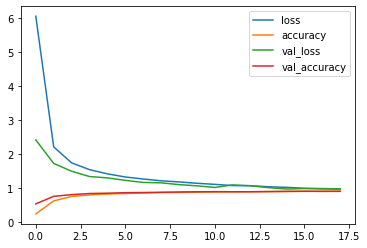

In [59]:
model_reg3 = Sequential()
model_reg3.add(BatchNormalization())
model_reg3.add(LSTM(
    128,
    input_shape=X.shape[1:],
    return_sequences=True,
    recurrent_regularizer=l1(0.01)
))
model_reg3.add(Dropout(0.5))
model_reg3.add(LSTM(128, return_sequences=True, recurrent_regularizer=l1(0.01)))
model_reg3.add(Dropout(0.5))
model_reg3.add(LSTM(128, recurrent_regularizer=l1(0.01)))
model_reg3.add(Dense(128, kernel_regularizer=l1(0.01)))
model_reg3.add(Dropout(0.5))
model_reg3.add(Dense(y.shape[1]))
model_reg3.add(Activation('softmax'))

model_reg3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
history_reg3 = model_reg3.fit(X_train, y_train, epochs=30, validation_split = 0.3, callbacks=[early_stop])
              
print(accuracy(model_reg3))

pd.DataFrame(history_reg3.history).plot()

**Models with different number of units**

Epoch 1/30
949/949 [==============================] - 101s 98ms/step - loss: 2.5881 - accuracy: 0.2434 - val_loss: 1.0454 - val_accuracy: 0.6986
Epoch 2/30
949/949 [==============================] - 94s 99ms/step - loss: 1.1170 - accuracy: 0.6790 - val_loss: 0.7349 - val_accuracy: 0.7879
Epoch 3/30
949/949 [==============================] - 94s 99ms/step - loss: 0.7822 - accuracy: 0.7813 - val_loss: 0.6113 - val_accuracy: 0.8234
Epoch 4/30
949/949 [==============================] - 89s 94ms/step - loss: 0.6484 - accuracy: 0.8226 - val_loss: 0.5655 - val_accuracy: 0.8381
Epoch 5/30
949/949 [==============================] - 90s 95ms/step - loss: 0.5540 - accuracy: 0.8481 - val_loss: 0.4884 - val_accuracy: 0.8633
Epoch 6/30
949/949 [==============================] - 76s 80ms/step - loss: 0.5034 - accuracy: 0.8648 - val_loss: 0.4379 - val_accuracy: 0.8756
Epoch 7/30
949/949 [==============================] - 90s 94ms/step - loss: 0.4478 - accuracy: 0.8751 - val_loss: 0.4276 - val_accuracy

<AxesSubplot:>

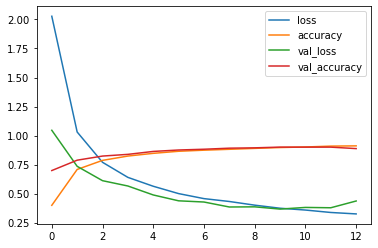

In [62]:
model_small = Sequential()
model_small.add(BatchNormalization())
model_small.add(LSTM(
    64,
    input_shape=X.shape[1:],
    return_sequences=True
))
model_small.add(Dropout(0.5))
model_small.add(LSTM(64, return_sequences=True))
model_small.add(Dropout(0.5))
model_small.add(LSTM(64))
model_small.add(Dense(64))
model_small.add(Dropout(0.5))
model_small.add(Dense(y.shape[1]))
model_small.add(Activation('softmax'))

model_small.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
history_small = model_small.fit(X_train, y_train, epochs=30, validation_split = 0.3, callbacks=[early_stop])
              
print(accuracy(model_small))

pd.DataFrame(history_small.history).plot()

Epoch 1/20
949/949 [==============================] - 380s 393ms/step - loss: 2.1607 - accuracy: 0.3679 - val_loss: 0.6834 - val_accuracy: 0.8015
Epoch 2/20
949/949 [==============================] - 387s 408ms/step - loss: 0.7061 - accuracy: 0.7996 - val_loss: 0.5294 - val_accuracy: 0.8485
Epoch 3/20
949/949 [==============================] - 525s 554ms/step - loss: 0.4950 - accuracy: 0.8592 - val_loss: 0.4356 - val_accuracy: 0.8743
Epoch 4/20
949/949 [==============================] - 550s 580ms/step - loss: 0.4133 - accuracy: 0.8786 - val_loss: 0.3766 - val_accuracy: 0.8922
Epoch 5/20
949/949 [==============================] - 382s 402ms/step - loss: 0.3515 - accuracy: 0.8977 - val_loss: 0.3457 - val_accuracy: 0.9000
Epoch 6/20
949/949 [==============================] - 354s 373ms/step - loss: 0.3110 - accuracy: 0.9117 - val_loss: 0.3592 - val_accuracy: 0.8977
Epoch 7/20
949/949 [==============================] - 537s 566ms/step - loss: 0.2774 - accuracy: 0.9180 - val_loss: 0.3443 -

<AxesSubplot:>

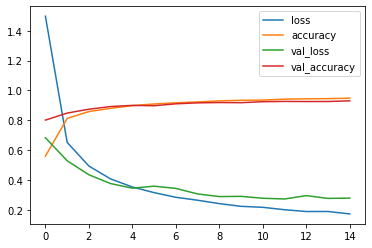

In [65]:
model_big = Sequential()
model_big.add(BatchNormalization())
model_big.add(LSTM(
    128,
    input_shape=X.shape[1:],
    return_sequences=True
))
model_big.add(Dropout(0.5))
model_big.add(LSTM(256, return_sequences=True))
model_big.add(Dropout(0.5))
model_big.add(LSTM(512))
model_big.add(Dense(256))
model_big.add(Dropout(0.5))
model_big.add(Dense(y.shape[1]))
model_big.add(Activation('softmax'))

model_big.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
history_big = model_big.fit(X_train, y_train, epochs=20, validation_split = 0.3, callbacks=[early_stop])
              
print(accuracy(model_big))

pd.DataFrame(history_big.history).plot()

**Smaller dropouts**

Epoch 1/30
949/949 [==============================] - 293s 293ms/step - loss: 2.0736 - accuracy: 0.3812 - val_loss: 0.8326 - val_accuracy: 0.7557
Epoch 2/30
949/949 [==============================] - 275s 290ms/step - loss: 0.7183 - accuracy: 0.7911 - val_loss: 0.5571 - val_accuracy: 0.8351
Epoch 3/30
949/949 [==============================] - 249s 263ms/step - loss: 0.5053 - accuracy: 0.8557 - val_loss: 0.4578 - val_accuracy: 0.8653
Epoch 4/30
949/949 [==============================] - 269s 284ms/step - loss: 0.4104 - accuracy: 0.8808 - val_loss: 0.3904 - val_accuracy: 0.8897
Epoch 5/30
949/949 [==============================] - 266s 280ms/step - loss: 0.3532 - accuracy: 0.8983 - val_loss: 0.3706 - val_accuracy: 0.8960
Epoch 6/30
949/949 [==============================] - 232s 245ms/step - loss: 0.2955 - accuracy: 0.9126 - val_loss: 0.3281 - val_accuracy: 0.9066
Epoch 7/30
949/949 [==============================] - 263s 278ms/step - loss: 0.2591 - accuracy: 0.9260 - val_loss: 0.3451 -

<AxesSubplot:>

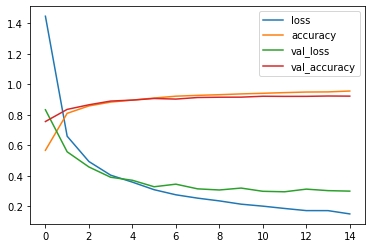

In [72]:
model_drop = Sequential()
model_drop.add(BatchNormalization())
model_drop.add(LSTM(
    128,
    input_shape=X.shape[1:],
    return_sequences=True
))
model_drop.add(Dropout(0.3))
model_drop.add(LSTM(128, return_sequences=True))
model_drop.add(Dropout(0.3))
model_drop.add(LSTM(128))
model_drop.add(Dense(128))
model_drop.add(Dropout(0.3))
model_drop.add(Dense(y.shape[1]))
model_drop.add(Activation('softmax'))

model_drop.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
history_drop = model_drop.fit(X_train, y_train, epochs=30, validation_split = 0.3, callbacks=[early_stop])
              
print(accuracy(model_drop))

pd.DataFrame(history_drop.history).plot()

**No dropouts**

Epoch 1/30
949/949 [==============================] - 292s 284ms/step - loss: 2.0169 - accuracy: 0.4033 - val_loss: 0.7256 - val_accuracy: 0.7860
Epoch 2/30
949/949 [==============================] - 233s 245ms/step - loss: 0.6369 - accuracy: 0.8147 - val_loss: 0.5760 - val_accuracy: 0.8282
Epoch 3/30
949/949 [==============================] - 264s 278ms/step - loss: 0.4460 - accuracy: 0.8679 - val_loss: 0.4366 - val_accuracy: 0.8700
Epoch 4/30
949/949 [==============================] - 265s 279ms/step - loss: 0.3514 - accuracy: 0.8967 - val_loss: 0.3734 - val_accuracy: 0.8901
Epoch 5/30
949/949 [==============================] - 231s 243ms/step - loss: 0.2940 - accuracy: 0.9118 - val_loss: 0.3403 - val_accuracy: 0.9023
Epoch 6/30
949/949 [==============================] - 263s 277ms/step - loss: 0.2475 - accuracy: 0.9260 - val_loss: 0.3322 - val_accuracy: 0.9062
Epoch 7/30
949/949 [==============================] - 265s 279ms/step - loss: 0.2209 - accuracy: 0.9318 - val_loss: 0.3517 -

<AxesSubplot:>

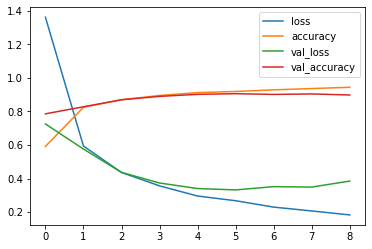

In [73]:
model_nodrop = Sequential()
model_nodrop.add(BatchNormalization())
model_nodrop.add(LSTM(
    128,
    input_shape=X.shape[1:],
    return_sequences=True
))
model_nodrop.add(LSTM(128, return_sequences=True))
model_nodrop.add(LSTM(128))
model_nodrop.add(Dense(128))
model_nodrop.add(Dense(y.shape[1]))
model_nodrop.add(Activation('softmax'))

model_nodrop.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
history_nodrop = model_nodrop.fit(X_train, y_train, epochs=30, validation_split = 0.3, callbacks=[early_stop])
              
print(accuracy(model_nodrop))

pd.DataFrame(history_nodrop.history).plot()

**More layers**

Epoch 1/30
949/949 [==============================] - 331s 330ms/step - loss: 2.2623 - accuracy: 0.3448 - val_loss: 0.8324 - val_accuracy: 0.7674
Epoch 2/30
949/949 [==============================] - 224s 236ms/step - loss: 0.8754 - accuracy: 0.7594 - val_loss: 0.6667 - val_accuracy: 0.8131
Epoch 3/30
949/949 [==============================] - 102s 108ms/step - loss: 0.6331 - accuracy: 0.8202 - val_loss: 0.5577 - val_accuracy: 0.8396
Epoch 4/30
949/949 [==============================] - 102s 108ms/step - loss: 0.5411 - accuracy: 0.8523 - val_loss: 0.4418 - val_accuracy: 0.8760
Epoch 5/30
949/949 [==============================] - 101s 107ms/step - loss: 0.4563 - accuracy: 0.8727 - val_loss: 0.4345 - val_accuracy: 0.8799
Epoch 6/30
949/949 [==============================] - 101s 106ms/step - loss: 0.4064 - accuracy: 0.8883 - val_loss: 0.4004 - val_accuracy: 0.8922
Epoch 7/30
949/949 [==============================] - 101s 107ms/step - loss: 0.3651 - accuracy: 0.8990 - val_loss: 0.3869 -

<AxesSubplot:>

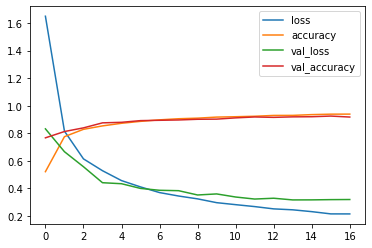

In [74]:
model_morelay = Sequential()
model_morelay.add(BatchNormalization())
model_morelay.add(LSTM(
    128,
    input_shape=X.shape[1:],
    return_sequences=True
))
model_morelay.add(Dropout(0.5))
model_morelay.add(LSTM(128, return_sequences=True))
model_morelay.add(Dropout(0.5))
model_morelay.add(LSTM(128, return_sequences=True))
model_morelay.add(Dropout(0.5))
model_morelay.add(LSTM(128))
model_morelay.add(Dense(128))
model_morelay.add(Dropout(0.5))
model_morelay.add(Dense(y.shape[1]))
model_morelay.add(Activation('softmax'))

model_morelay.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
history_morelay = model_morelay.fit(X_train, y_train, epochs=30, validation_split = 0.3, callbacks=[early_stop])
              
print(accuracy(model_morelay))

pd.DataFrame(history_morelay.history).plot()

**Less layers**

Epoch 1/30
949/949 [==============================] - 64s 64ms/step - loss: 2.3714 - accuracy: 0.3030 - val_loss: 0.7879 - val_accuracy: 0.7629
Epoch 2/30
949/949 [==============================] - 60s 63ms/step - loss: 0.8080 - accuracy: 0.7678 - val_loss: 0.5291 - val_accuracy: 0.8456
Epoch 3/30
949/949 [==============================] - 58s 61ms/step - loss: 0.5486 - accuracy: 0.8422 - val_loss: 0.4714 - val_accuracy: 0.8613
Epoch 4/30
949/949 [==============================] - 56s 59ms/step - loss: 0.4667 - accuracy: 0.8663 - val_loss: 0.4352 - val_accuracy: 0.8711
Epoch 5/30
949/949 [==============================] - 56s 59ms/step - loss: 0.3747 - accuracy: 0.8919 - val_loss: 0.4049 - val_accuracy: 0.8854
Epoch 6/30
949/949 [==============================] - 56s 59ms/step - loss: 0.3328 - accuracy: 0.9054 - val_loss: 0.3682 - val_accuracy: 0.8980
Epoch 7/30
949/949 [==============================] - 56s 59ms/step - loss: 0.2987 - accuracy: 0.9132 - val_loss: 0.3462 - val_accuracy:

<AxesSubplot:>

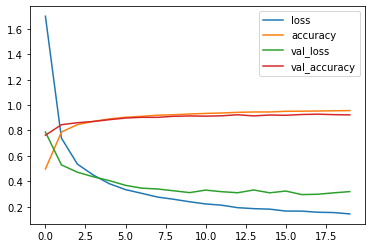

In [75]:
model_lesslay = Sequential()
model_lesslay.add(BatchNormalization())
model_lesslay.add(LSTM(
    128,
    input_shape=X.shape[1:],
    return_sequences=True
))
model_lesslay.add(Dropout(0.5))
model_lesslay.add(LSTM(128))
model_lesslay.add(Dense(128))
model_lesslay.add(Dropout(0.5))
model_lesslay.add(Dense(y.shape[1]))
model_lesslay.add(Activation('softmax'))

model_lesslay.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
history_lesslay = model_lesslay.fit(X_train, y_train, epochs=30, validation_split = 0.3, callbacks=[early_stop])
              
print(accuracy(model_lesslay))

pd.DataFrame(history_lesslay.history).plot()

**Different activations**

Epoch 1/30
949/949 [==============================] - 64s 65ms/step - loss: 3.4497 - accuracy: 0.0373 - val_loss: 3.0086 - val_accuracy: 0.0775
Epoch 2/30
949/949 [==============================] - 62s 65ms/step - loss: 2.9321 - accuracy: 0.0945 - val_loss: 2.4111 - val_accuracy: 0.2287
Epoch 3/30
949/949 [==============================] - 62s 65ms/step - loss: 2.2852 - accuracy: 0.2549 - val_loss: 1.7479 - val_accuracy: 0.4276
Epoch 4/30
949/949 [==============================] - 62s 65ms/step - loss: 1.8219 - accuracy: 0.3918 - val_loss: 1.5074 - val_accuracy: 0.5066
Epoch 5/30
949/949 [==============================] - 61s 65ms/step - loss: 1.5608 - accuracy: 0.4817 - val_loss: 1.3165 - val_accuracy: 0.5731
Epoch 6/30
949/949 [==============================] - 61s 65ms/step - loss: 1.3934 - accuracy: 0.5488 - val_loss: 1.1721 - val_accuracy: 0.6265
Epoch 7/30
949/949 [==============================] - 61s 65ms/step - loss: 1.2575 - accuracy: 0.6033 - val_loss: 1.0445 - val_accuracy:

<AxesSubplot:>

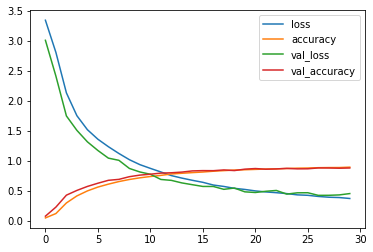

In [76]:
model_act = Sequential()
model_act.add(BatchNormalization())
model_act.add(LSTM(
    128,
    input_shape=X.shape[1:],
    return_sequences=True,
    activation='sigmoid'
))
model_act.add(Dropout(0.5))
model_act.add(LSTM(128, activation ='sigmoid'))
model_act.add(Dense(128, activation ='sigmoid'))
model_act.add(Dropout(0.5))
model_act.add(Dense(y.shape[1]))
model_act.add(Activation('softmax'))

model_act.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
history_act = model_act.fit(X_train, y_train, epochs=30, validation_split = 0.3, callbacks=[early_stop])
              
print(accuracy(model_act))

pd.DataFrame(history_act.history).plot()